<a href="https://colab.research.google.com/github/star-plant/ENFU-AI-SEMI/blob/main/study/snntorch/tutorial_5_FCN_kr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)


# snnTorch - Training Spiking Neural Networks with snnTorch
## Tutorial 5
### By Jason K. Eshraghian (www.ncg.ucsc.edu)

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_6_CNN.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)

The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>



# Introduction


이 튜토리얼에서는 다음 내용을 학습합니다.
- 발화 뉴런(spiking neuron)이 재귀 네트워크(recurrent network)로 구현되는 방식
- 시간 역전파(Backpropagation Through Time, BPTT)와, 스파이크의 **비미분성(non-differentiability)** 등 SNN에서 발생하는 학습 관련 문제
- 정적 MNIST 데이터셋을 이용한 완전연결 네트워크 학습 방법

<!-- * 다양한 역전파 전략 구현:
  * Backpropagation Through Time
  * Truncated-Backpropagation Through Time
  * Real-Time Recurrent Learning -->

> 이 튜토리얼의 일부 내용은 Friedemann Zenke의 SNN 관련 연구에서 영감을 받았습니다.  
> 대리 그래디언트(surrogate gradient)에 대한 그의 GitHub 저장소는 [여기](https://github.com/fzenke/spytorch)에서 확인할 수 있으며,  
> 제가 좋아하는 논문 중 하나는 다음과 같습니다:  
> E. O. Neftci, H. Mostafa, F. Zenke, [Surrogate Gradient Learning in Spiking Neural Networks: Bringing the Power of Gradient-based optimization to spiking neural networks.](https://ieeexplore.ieee.org/document/8891809) IEEE Signal Processing Magazine 36, 51–63.

---

튜토리얼의 마지막에는 기본적인 **지도 학습 알고리즘**을 구현합니다.  
원본 정적 MNIST 데이터셋을 사용하여, 다층 완전연결 발화 신경망을  
경사하강법(gradient descent)으로 학습시켜 이미지 분류를 수행합니다.

---

Google Colab에서 실행 시:
- 메뉴에서 `Runtime` > `Change runtime type` > `Hardware accelerator: GPU`를 선택해 GPU를 연결할 수 있습니다.
- 그다음, 아래 셀을 클릭하고 `Shift+Enter`를 눌러 snnTorch의 최신 PyPi 배포판을 설치하세요.


If running in Google Colab:
* You may connect to GPU by checking `Runtime` > `Change runtime type` > `Hardware accelerator: GPU`
* Next, install the latest PyPi distribution of snnTorch by clicking into the following cell and pressing `Shift+Enter`.

In [1]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 7.7 MB/s eta 0:00:00


In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

# 1. A Recurrent Representation of SNNs

튜토리얼 3에서는 LIF(Leaky Integrate-and-Fire) 뉴런의 재귀적 표현을 다음과 같이 유도했습니다.

$$U[t+1] = \underbrace{\beta U[t]}_\text{감쇠(decay)} + \underbrace{WX[t+1]}_\text{입력(input)} - \underbrace{R[t]}_\text{리셋(reset)} \tag{1}$$

여기서 입력 시냅스 전류는 $I_{\rm in}[t] = WX[t]$로 해석되며,  
$X[t]$는 임의의 스파이크 입력, 계단(step) 또는 시간 가변 전압,  
혹은 가중치가 없는(step/time-varying) 전류가 될 수 있습니다.  

발화(spiking)는 다음 식으로 나타내며, 막전위가 임계값을 초과하면 스파이크가 발생합니다.

$$S[t] = \begin{cases} 1, &\text{if}~U[t] > U_{\rm thr} \\
0, &\text{그 외 경우} \end{cases} \tag{2}$$

---

이러한 **이산(discrete)**·**재귀(recursive)** 형태의 스파이킹 뉴런은  
순환 신경망(RNN) 및 시퀀스 기반 모델 학습 기법을 그대로 활용하기에 매우 적합합니다.  

이는 막전위 감쇠를 **암시적(implicit)** 순환 연결로 표현한 것으로,  
출력 스파이크 $S_{\rm out}$을 다시 입력으로 되돌리는 **명시적(explicit)** 순환과 구분됩니다.  
아래 그림에서 $-U_{\rm thr}$ 가중치로 연결된 선은 리셋 메커니즘 $R[t]$를 나타냅니다.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial5/unrolled_2.png?raw=true' width="800">
</center>

---

**Unrolled graph**의 장점은 연산이 수행되는 과정을 명시적으로 보여준다는 점입니다.  
그래프를 펼치면(언롤링) 시간 방향(왼쪽→오른쪽)으로 정보가 전파되며 출력과 손실을 계산하고,  
다시 시간 역방향으로 그래디언트를 계산하는 흐름이 나타납니다.  
시뮬레이션 시간 스텝이 길어질수록 그래프 깊이도 깊어집니다.

일반적인 RNN에서는 $\beta$를 학습 가능한 파라미터로 설정하지만,  
SNN에서는 기본적으로 **하이퍼파라미터**로 취급합니다.  
이렇게 하면 기울기 소실/폭발(vanishing/exploding gradient) 문제를  
하이퍼파라미터 탐색 문제로 대체할 수 있습니다.  

향후 튜토리얼에서는 $\beta$를 학습 가능한 파라미터로 만드는 방법을 다룰 예정입니다.


# 2. 스파이크의 비미분성(Non-Differentiability)
## 2.1 역전파 알고리즘을 사용한 학습

식 (2)에서 $S$와 $U$의 관계를 다음과 같이 표현할 수도 있습니다.

$$S[t] = \Theta(U[t] - U_{\rm thr}) \tag{3}$$

여기서 $\Theta(\cdot)$는 헤비사이드(Heaviside) 스텝 함수입니다.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial3/3_2_spike_descrip.png?raw=true' width="600">
</center>

---

이 형태로 네트워크를 학습시키려면 심각한 문제가 발생합니다.  
아래 *forward pass* 그림은 앞서 소개한 *Recurrent representation of spiking neurons* 그림에서  
단일, 독립된 시간 스텝을 떼어낸 계산 그래프입니다.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial5/non-diff.png?raw=true' width="400">
</center>

---

목표는 가중치에 대한 손실 함수의 기울기를 구해,  
가중치를 업데이트하여 손실을 최소화하는 것입니다.  
역전파(backpropagation) 알고리즘은 이를 **연쇄 법칙(chain rule)**을 통해 수행합니다.

$$\frac{\partial \mathcal{L}}{\partial W} =
\frac{\partial \mathcal{L}}{\partial S}
\underbrace{\frac{\partial S}{\partial U}}_{\{0, \infty\}}
\frac{\partial U}{\partial I}\
\frac{\partial I}{\partial W} \tag{4}$$

식 (1)로부터,  
$\partial I/\partial W = X$,  
$\partial U/\partial I = 1$ 입니다.  

아직 손실 함수를 정의하지는 않았지만,  
$\partial \mathcal{L} / \partial S$는 크로스엔트로피(Cross-Entropy)나  
평균제곱오차(MSE)와 같은 형태로 해석적 계산이 가능하다고 가정할 수 있습니다.

---

하지만 우리가 직면하게 되는 문제는 $\partial S / \partial U$ 항입니다.  
식 (3)의 헤비사이드 스텝 함수의 도함수는 **디랙 델타(Dirac Delta) 함수**로,  
임계값 $U_{\rm thr} = \theta$에서만 무한대에 발산하고,  
그 외의 모든 구간에서는 0이 됩니다.

이 말은 곧, 그래디언트가 거의 항상 0이 되어 학습이 불가능하다는 뜻이며,  
혹은 $U$가 임계값에 정확히 걸린 경우 그래디언트가 포화(saturation) 상태에 빠집니다.  

이 현상을 **Dead Neuron Problem**이라고 부릅니다.


## 2.2 Dead Neuron 문제 극복하기

Dead Neuron 문제를 해결하는 가장 일반적인 방법은,  
**순전파(forward pass)**에서는 헤비사이드 함수를 그대로 사용하되,  
**역전파(backward pass)**에서는 $\partial S / \partial U$ 항을  
학습을 방해하지 않는 다른 형태로 교체하는 것입니다.  
이 교체된 기울기를 $\partial \tilde{S} / \partial U$로 표기합니다.  

이 방식이 다소 어색하게 들릴 수 있지만,  
신경망은 이러한 근사에도 꽤 강건하다는 것이 밝혀졌습니다.  
이 접근법은 일반적으로 **대리 그래디언트(surrogate gradient)** 방법이라고 부릅니다.

---

대리 그래디언트를 사용하는 방법에는 여러 가지 변형이 있으며,  
자세한 내용은 [튜토리얼 6](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)에서 다룰 예정입니다.  

snnTorch v0.6.0 기준 기본 방식은  
헤비사이드 함수를 **아크탄젠트(arctangent)** 함수로 스무딩(smoothing)하는 것입니다.  
역전파에서 사용하는 도함수는 다음과 같습니다.

$$ \frac{\partial \tilde{S}}{\partial U} \leftarrow \frac{1}{\pi}\frac{1}{(1+[U\pi]^2)} \tag{5}$$

여기서 왼쪽 화살표(←)는 **대체(substitution)**를 의미합니다.

---

아래는 식 (1)~(2)에서 설명한 것과 동일한 뉴런 모델(`snn.Leaky`, 튜토리얼 3 참조)을  
PyTorch로 구현한 예시입니다.  
아직 코드를 몰라도 괜찮습니다.  
곧 snnTorch를 사용해 이 과정을 단 한 줄로 구현하게 됩니다.


In [3]:
# Leaky neuron model, overriding the backward pass with a custom function
class LeakySurrogate(nn.Module):
  def __init__(self, beta, threshold=1.0):
      super(LeakySurrogate, self).__init__()

      # initialize decay rate beta and threshold
      self.beta = beta
      self.threshold = threshold
      self.spike_gradient = self.ATan.apply

  # the forward function is called each time we call Leaky
  def forward(self, input_, mem):
    spk = self.spike_gradient((mem-self.threshold))  # call the Heaviside function
    reset = (self.beta * spk * self.threshold).detach() # remove reset from computational graph
    mem = self.beta * mem + input_ - reset # Eq (1)
    return spk, mem

  # Forward pass: Heaviside function
  # Backward pass: Override Dirac Delta with the ArcTan function
  @staticmethod
  class ATan(torch.autograd.Function):
      @staticmethod
      def forward(ctx, mem):
          spk = (mem > 0).float() # Heaviside on the forward pass: Eq(2)
          ctx.save_for_backward(mem)  # store the membrane for use in the backward pass
          return spk

      @staticmethod
      def backward(ctx, grad_output):
          (mem,) = ctx.saved_tensors  # retrieve the membrane potential
          grad = 1 / (1 + (np.pi * mem).pow_(2)) * grad_output # Eqn 5
          return grad

리셋(reset) 메커니즘은 연산 그래프(computational graph)에서 **detach**되어 있다는 점에 유의해야 합니다.  
이는 대리 그래디언트(surrogate gradient)가 $\partial S / \partial U$에만 적용되어야 하며,  
$\partial R / \partial U$에는 적용되지 않기 때문입니다.

---

위 뉴런은 다음과 같이 생성할 수 있습니다.


In [24]:
lif1 = LeakySurrogate(beta=0.9)

이 뉴런은 이전 튜토리얼과 마찬가지로 `for` 루프를 사용해 시뮬레이션할 수 있으며,  
PyTorch의 자동미분(autodiff) 기능이 백그라운드에서 그래디언트를 추적합니다.

또는, 동일한 작업을 `snn.Leaky` 뉴런을 호출하는 것만으로도 수행할 수 있습니다.  
실제로 snnTorch에서 어떤 뉴런 모델을 호출하더라도,  
기본적으로 **ATan** 대리 그래디언트가 적용됩니다.


In [5]:
lif1 = snn.Leaky(beta=0.9)

If you would like to explore how this neuron behaves, then refer to [Tutorial 3](https://snntorch.readthedocs.io/en/latest/tutorials/index.html).

# 3. 시간 역전파(Backprop Through Time, BPTT)

식 (4)는 단일 시간 스텝에 대한 기울기만 계산합니다  
(아래 그림에서 *immediate influence*로 표시).  
반면, **시간 역전파(BPTT)** 알고리즘은 손실로부터 *모든* 후속 노드(descendants)까지의  
기울기를 계산하여 합산합니다.

---

가중치 $W$는 모든 시간 스텝에 동일하게 적용되므로,  
매 시간 스텝에서 손실이 계산된다고 가정하면,  
현재와 과거의 손실에 대한 $W$의 영향을 모두 합산하여  
전체 기울기(global gradient)를 정의해야 합니다.

$$
\frac{\partial \mathcal{L}}{\partial W}
= \sum_t \frac{\partial\mathcal{L}[t]}{\partial W}
= \sum_t \sum_{s\leq t} \frac{\partial\mathcal{L}[t]}{\partial W[s]}
\frac{\partial W[s]}{\partial W} \tag{5}
$$

---

식 (5)의 핵심은 **인과성(causality)**을 보장하는 것입니다.  
$s \leq t$로 제한함으로써, 손실에 대한 $W$의 직접적·이전 영향만 고려합니다.  
순환 시스템에서는 모든 스텝에서 동일한 가중치를 공유합니다:  
$W[0] = W[1] = \dots = W$.  
따라서 $W[s]$의 변화는 모든 $W$에 동일한 영향을 주며,  
이는 $\partial W[s] / \partial W = 1$을 의미합니다.

$$
\frac{\partial \mathcal{L}}{\partial W}
= \sum_t \sum_{s\leq t} \frac{\partial\mathcal{L}[t]}{\partial W[s]} \tag{6}
$$

---

예시로, $s = t-1$일 때의 **직전 영향(prior influence)**만 고립시켜 봅시다.  
이는 역전파가 한 스텝 이전까지 거슬러 올라가야 함을 의미합니다.  
이 경우 $W[t-1]$의 손실에 대한 영향은 다음과 같이 표현됩니다.

$$
\frac{\partial \mathcal{L}[t]}{\partial W[t-1]} =
\frac{\partial \mathcal{L}[t]}{\partial S[t]}
\underbrace{\frac{\partial \tilde{S}[t]}{\partial U[t]}}_{\text{Eq.~(5)}}
\underbrace{\frac{\partial U[t]}{\partial U[t-1]}}_{\beta}
\underbrace{\frac{\partial U[t-1]}{\partial I[t-1]}}_{1}
\underbrace{\frac{\partial I[t-1]}{\partial W[t-1]}}_{X[t-1]} \tag{7}
$$

---

식 (4)에서 이미 다룬 항들 외에,  
$\partial U[t] / \partial U[t-1]$만 남았는데,  
이는 식 (1)로부터 단순히 $\beta$가 됩니다.

즉, 원한다면 이제 단일 뉴런에 대해  
모든 시간 스텝에서의 각 가중치 기울기를  
수작업으로 계산할 수 있게 된 것입니다.  
아래 그림은 그 예시입니다.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial5/bptt.png?raw=true' width="600">
</center>

---

다행히도, PyTorch의 자동미분(autodiff)이  
이 모든 과정을 백그라운드에서 처리해줍니다.

*참고: 위 그림에서는 리셋 메커니즘이 생략되어 있습니다.  
snnTorch에서는 리셋이 순전파(forward pass)에는 포함되지만,  
역전파(backward pass)에서는 detach됩니다.*


# 4. 손실 함수 설정 / 출력 디코딩

일반적인 비스파이킹 신경망에서는 지도 학습 다중 클래스 분류 문제에서, 가장 활성화 값이 높은 뉴런을 예측 클래스라고 판단합니다.  
스파이킹 신경망에서는 출력 스파이크를 해석하는 방법이 여러 가지가 있으며, 가장 일반적인 방식은 다음과 같습니다:
* **Rate coding:** 발화율(또는 스파이크 개수)이 가장 높은 뉴런을 예측 클래스로 선택
* **Latency coding:** 가장 먼저 발화하는 뉴런을 예측 클래스로 선택

이는 [튜토리얼 1: 뉴럴 인코딩](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)과 유사하지만, 여기서는 입력 데이터를 스파이크로 변환(인코딩)하는 것이 아니라, 출력 스파이크를 해석(디코딩)하는 과정입니다.

여기서는 Rate coding에 집중합니다. 입력 데이터가 네트워크에 전달되면, 정답 클래스 뉴런이 시뮬레이션 동안 가장 많은 스파이크를 발생시키도록 합니다. 이는 가장 높은 평균 발화 빈도에 해당합니다. 이를 위해 정답 클래스의 막전위를 $U>U_{\rm thr}$로, 오답 클래스의 막전위를 $U<U_{\rm thr}$로 유도합니다. 타겟을 $U$에 적용하는 것은 $S$의 발화 행동을 조절하는 간접적인 방법입니다.

이를 구현하기 위해 출력 뉴런의 막전위에 소프트맥스를 적용합니다($C$는 출력 클래스 수):
$$p_i[t] = \frac{e^{U_i[t]}}{\sum_{j=0}^{C}e^{U_j[t]}} \tag{8}$$

그리고, $p_i$와 타겟 $y_i \in \{0,1\}^C$ (원-핫 벡터)의 크로스 엔트로피는 다음과 같이 계산합니다:
$$\mathcal{L}_{CE}[t] = -\sum_{i=0}^Cy_i{\rm log}(p_i[t]) \tag{9}$$

이 방식의 효과는, 정답 클래스의 막전위는 증가시키고 오답 클래스의 막전위는 감소시키는 것입니다. 결과적으로 정답 클래스는 모든 시뮬레이션 스텝에서 발화하도록 유도되고, 오답 클래스는 모든 스텝에서 억제됩니다. 이는 SNN을 구현하는 가장 효율적인 방법은 아니지만, 가장 단순한 방법 중 하나입니다.

이 타겟은 시뮬레이션의 모든 시간 스텝에서 적용되며, 각 스텝마다 손실이 생성됩니다. 마지막에 이 손실들을 모두 합산합니다:
$$\mathcal{L}_{CE} = \sum_t\mathcal{L}_{CE}[t] \tag{10}$$

이는 SNN에 손실 함수를 적용하는 방법 중 하나일 뿐입니다. snnTorch(`snn.functional` 모듈)에는 다양한 방법이 제공되며, 이는 향후 튜토리얼에서 다룰 예정입니다.

이제 이론적 배경을 모두 다뤘으니, 완전연결 스파이킹 신경망 학습으로 들어가겠습니다.


# 5. Setting up the Static MNIST Dataset

In [6]:
# dataloader arguments
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.11MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 136kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.59MB/s]


If the above code blocks throws an error, e.g. the MNIST servers are down, then uncomment the following code instead.

In [8]:
# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

# mnist_train = datasets.MNIST(root = './', train=True, download=True, transform=transform)
# mnist_test = datasets.MNIST(root = './', train=False, download=True, transform=transform)

In [9]:
# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

# 6. Define the Network

In [10]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

In [11]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

`forward()` 함수의 코드는 입력 인자 `x`가 `net`에 명시적으로 전달될 때만 호출됩니다.

- `fc1`: MNIST 데이터셋의 모든 입력 픽셀에 선형 변환(linear transformation)을 적용
- `lif1`: 가중합 입력을 시간에 따라 적분하며, 임계값 조건을 만족하면 스파이크를 발생
- `fc2`: `lif1`의 출력 스파이크에 선형 변환을 적용
- `lif2`: 또 하나의 발화 뉴런 계층으로, 가중된 스파이크를 시간에 따라 적분


# 7. Training the SNN

## 7.1 Accuracy Metric
아래 함수는 배치(batch) 데이터를 입력으로 받아,  
각 뉴런이 시뮬레이션 동안 발생시킨 모든 스파이크를 합산하여 발화율(rate code)을 계산합니다.  
그 후, 스파이크 개수가 가장 많은 뉴런의 인덱스를 실제 타겟과 비교합니다.  
만약 일치한다면, 네트워크가 해당 타겟을 올바르게 예측한 것입니다.


In [12]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

## 7.2 Loss Definition
PyTorch의 `nn.CrossEntropyLoss` 함수는 출력 계층에 대한 소프트맥스 연산과 손실(loss) 계산을 자동으로 처리합니다.


In [13]:
loss = nn.CrossEntropyLoss()

## 7.3 Optimizer
Adam은 순환 신경망에서 성능이 우수한 안정적인 옵티마이저이므로, 학습률을 $5\times10^{-4}$로 설정하여 사용하겠습니다.


In [14]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

## 7.4 One Iteration of Training
Take the first batch of data and load it onto CUDA if available.

In [15]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

입력 데이터를 크기 $784$의 벡터로 평탄화(flatten)한 뒤, 이를 네트워크에 전달합니다.


In [16]:
spk_rec, mem_rec = net(data.view(batch_size, -1))
print(mem_rec.size())

torch.Size([25, 128, 10])


막전위(membrane potential) 기록은 다음 조건에서 이루어집니다.
- 시간 스텝: 25
- 데이터 샘플 수: 128
- 출력 뉴런 수: 10

식 (10)에 따라, 모든 시간 스텝에서 손실을 계산한 뒤 이를 합산합니다.


In [17]:
# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")

Training loss: 57.644


손실 값이 크게 나타나는 이유는, 25개 시간 스텝의 손실을 모두 합산했기 때문입니다.  
또한 네트워크가 아직 학습되지 않았으므로, 정확도는 약 10% 수준으로 매우 낮게 나옵니다:

In [18]:
print_batch_accuracy(data, targets, train=True)

Train set accuracy for a single minibatch: 20.31%


A single weight update is applied to the network as follows:

In [19]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

Now, re-run the loss calculation and accuracy after a single iteration:

In [20]:
# calculate new network outputs using the same data
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 50.804
Train set accuracy for a single minibatch: 64.84%


After only one iteration, the loss should have decreased and accuracy should have increased. Note how membrane potential is used to calculate the cross entropy
loss, and spike count is used for the measure of accuracy. It is also possible to use the spike count in the loss ([see Tutorial 6](https://snntorch.readthedocs.io/en/latest/tutorials/index.html))

## 7.5 Training Loop

Let's combine everything into a training loop. We will train for one epoch (though feel free to increase `num_epochs`), exposing our network to each sample of data once.

In [21]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 53.40
Test Set Loss: 49.99
Train set accuracy for a single minibatch: 70.31%
Test set accuracy for a single minibatch: 56.25%


Epoch 0, Iteration 50
Train Set Loss: 18.09
Test Set Loss: 9.95
Train set accuracy for a single minibatch: 85.94%
Test set accuracy for a single minibatch: 88.28%


Epoch 0, Iteration 100
Train Set Loss: 12.05
Test Set Loss: 7.58
Train set accuracy for a single minibatch: 86.72%
Test set accuracy for a single minibatch: 92.19%


Epoch 0, Iteration 150
Train Set Loss: 7.66
Test Set Loss: 17.24
Train set accuracy for a single minibatch: 89.84%
Test set accuracy for a single minibatch: 89.06%


Epoch 0, Iteration 200
Train Set Loss: 7.00
Test Set Loss: 6.68
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 87.50%


Epoch 0, Iteration 250
Train Set Loss: 5.86
Test Set Loss: 6.39
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 92.19%


Epoch 0,

If this was your first time training an SNN, then congratulations!

# 8. Results
## 8.1 Plot Training/Test Loss

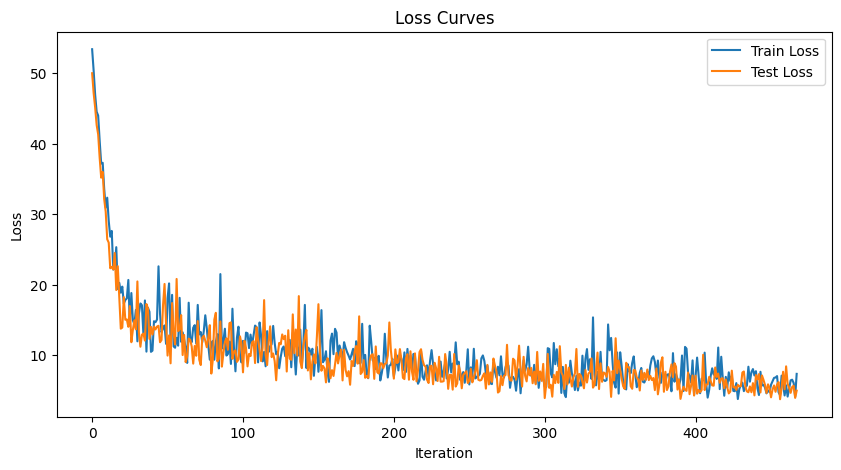

In [22]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

The loss curves are noisy because the losses are tracked at every iteration, rather than averaging across multiple iterations.

## 8.2 Test Set Accuracy
This function iterates over all minibatches to obtain a measure of accuracy over the full 10,000 samples in the test set.

In [23]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9246/10000
Test Set Accuracy: 92.46%


Voila! That's it for static MNIST. Feel free to tweak the network parameters, hyperparameters, decay rate, using a learning rate scheduler etc. to see if you can improve the network performance.

# Conclusion
Now you know how to construct and train a fully-connected network on a static dataset. The spiking neurons can also be adapted to other layer types, including convolutions and skip connections. Armed with this knowledge, you should now be able to build many different types of SNNs. [In the next tutorial](https://snntorch.readthedocs.io/en/latest/tutorials/index.html), you will learn how to train a spiking convolutional network, and simplify the amount of code required using the `snn.backprop` module.

Also, a special thanks to Bugra Kaytanli for providing valuable feedback on the tutorial.

If you like this project, please consider starring ⭐ the repo on GitHub as it is the easiest and best way to support it.


# Additional Resources

* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)